# Setup FlowNet2

In [1]:
import os
os.chdir('/content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation')

In [3]:
! pwd #/content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation

/content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation


In [4]:
! pip install torch==1.0.0 torchvision==0.2.2 -f https://download.pytorch.org/whl/cu90/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu90/torch_stable.html
     |████████████████████████████████| 591.8 MB 687 bytes/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 52 kB 1.2 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.62.3
    Uninstalling tqdm-4.62.3:
      Successfully uninstalled tqdm-4.62.3
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.0.0 wh

In [5]:
import os
# get flownet2-pytorch source
!git clone https://github.com/NVIDIA/flownet2-pytorch.git
!mv ./flownet2-pytorch ./flownet2pytorch
# change dir to ./flownet2pytorch!!!
os.chdir('./flownet2pytorch')

Cloning into 'flownet2-pytorch'...
remote: Enumerating objects: 557, done.
remote: Total 557 (delta 0), reused 0 (delta 0), pack-reused 557
Receiving objects: 100% (557/557), 6.28 MiB | 11.82 MiB/s, done.
Resolving deltas: 100% (312/312), done.


In [6]:
! bash install.sh #Must be run inside flownet2pytorch!!!

running install
running bdist_egg
running egg_info
creating correlation_cuda.egg-info
writing correlation_cuda.egg-info/PKG-INFO
writing dependency_links to correlation_cuda.egg-info/dependency_links.txt
writing top-level names to correlation_cuda.egg-info/top_level.txt
writing manifest file 'correlation_cuda.egg-info/SOURCES.txt'
writing manifest file 'correlation_cuda.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'correlation_cuda' extension
creating build
creating build/temp.linux-x86_64-3.7
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -g -fdebug-prefix-map=/build/python3.7-Y7dWVB/python3.7-3.7.12=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.7/dist-packages/to

In [7]:
# Should contains:
# channelnorm_cuda-0.0.0-py3.7-linux-x86_64.egg
# correlation_cuda-0.0.0-py3.7-linux-x86_64.egg
# easy-install.pth
# resample2d_cuda-0.0.0-py3.7-linux-x86_64.egg

! cd /root/.local/lib/python3.7/site-packages && ls -l

total 16
drwxr-xr-x 4 root root 4096 Dec 21 21:38 channelnorm_cuda-0.0.0-py3.7-linux-x86_64.egg
drwxr-xr-x 4 root root 4096 Dec 21 21:37 correlation_cuda-0.0.0-py3.7-linux-x86_64.egg
-rw-r--r-- 1 root root  143 Dec 21 21:38 easy-install.pth
drwxr-xr-x 4 root root 4096 Dec 21 21:37 resample2d_cuda-0.0.0-py3.7-linux-x86_64.egg


In [2]:
# pay attention to the python version and package location!
import os
os.sys.path.append('/root/.local/lib/python3.7/site-packages/resample2d_cuda-0.0.0-py3.7-linux-x86_64.egg')
os.sys.path.append('/root/.local/lib/python3.7/site-packages/correlation_cuda-0.0.0-py3.7-linux-x86_64.egg')
os.sys.path.append( '/root/.local/lib/python3.7/site-packages/channelnorm_cuda-0.0.0-py3.7-linux-x86_64.egg')

In [9]:
# change directory back
os.chdir('..')

In [3]:
! pwd

/content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation


# Base Model

In [ ]:
os.sys.path.append('/content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation')

In [ ]:
! pip3 install -y tensorboard

In [ ]:
from base import BaseModel

In [ ]:
from base import BaseModel
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.utils.model_zoo as model_zoo
from utils.helpers import initialize_weights
from utils.helpers import set_trainable
from itertools import chain
from torchsummary import summary

In [ ]:
class ResNet(nn.Module):

  def __init__(self, in_channels=3, output_stride=16, backbone='resnet101', pretrained=True):
    super(ResNet, self).__init__()

    # only output strides of 8 or 16 are supported
    assert output_stride in [8,16]

    # get a attribute 'backbone' from class 'models'
    # The same as model = models.resnet101(True)
    model = getattr(models, backbone)(pretrained)

    # The first conv2d layer 
    self.layer0 = nn.Sequential(*list(model.children())[:4])
    # sequential layers
    self.layer1 = model.layer1
    self.layer2 = model.layer2
    self.layer3 = model.layer3
    self.layer4 = model.layer4

    if output_stride == 16:
      s3,s4,d3,d4 = (2,1,1,2)
    elif output_stride == 8:
      s3,s4,d3,d4 = (1,1,2,4)
    
    if output_stride == 8:
      for name,model in self.layer3.named_modules():
        if 'conv1' in name and (backbone == 'resnet34' or backbone == 'resnet18'):
          model.dilation, model.padding, model.stride = (d3,d3), (d3,d3), (s3,s3)
        elif 'conv2' in name:
          model.dilation, model.padding, model.stride = (d3,d3), (d3,d3), (s3,s3)
        elif 'downsample.0' in name:
          model.stride = (s3,s3)
    
    for name,model in self.layer4.named_modules():
      if 'conv1' in name and (backbone == 'resnet34' or backbone == 'resnet18'):
        model.dilation, model.padding, model.stride = (d4,d4), (d4,d4), (s4,s4)
      elif 'conv2' in name:
        model.dilation, model.padding, model.stride = (d4,d4), (d4,d4), (s4,s4)
      elif 'downsample.0' in name:
        model.stride = (s4, s4)

  def forward(self,x):
    x = self.layer0(x)
    x = self.layer1(x)
    # Deep Feature Flow doesn't use low_level_features at all
    low_level_features = x
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    # result shape is [-1,2048,Height/16,Width/16]
    return x, low_level_features

In [ ]:
def assp_branch(in_channels, out_channles, kernel_size, dilation):
    padding = 0 if kernel_size == 1 else dilation
    return nn.Sequential(
            nn.Conv2d(in_channels, out_channles, kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channles),
            nn.ReLU(inplace=True))

In [ ]:
class ASSP(nn.Module):

  def __init__(self, in_channels, output_stride):
    super(ASSP, self).__init__()

    assert output_stride in [8, 16], 'Only output strides of 8 or 16 are suported'
    if output_stride == 16: dilations = [1, 6, 12, 18]
    elif output_stride == 8: dilations = [1, 12, 24, 36]

    self.assp1 = assp_branch(in_channels, 256, 1, dilation=dilations[0])
    self.assp2 = assp_branch(in_channels, 256, 1, dilation=dilations[1])
    self.assp3 = assp_branch(in_channels, 256, 1, dilation=dilations[2])
    self.assp4 = assp_branch(in_channels, 256, 1, dilation=dilations[3])

    self.avg_pool = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Conv2d(in_channels, 256, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True))
    
    self.conv1 = nn.Conv2d(256*5, 256, 1, bias=False)
    self.bn1 = nn.BatchNorm2d(256)
    self.relu = nn.ReLU(inplace=True)
    self.dropout = nn.Dropout(0.5)

    initialize_weights(self)

  def forward(self, x):
    x1 = self.assp1(x)
    x2 = self.assp2(x)
    x3 = self.assp3(x)
    x4 = self.assp4(x)
    x5 = F.interpolate(self.avg_pool(x), size=(x.size(2), x.size(3)), mode='bilinear', align_corners=True)

    x = self.conv1(torch.cat((x1, x2, x3, x4, x5),dim=1))
    x = self.bn1(x)
    x = self.dropout(self.relu(x))

    return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, low_level_channels, num_classes):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(low_level_channels, 48, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.relu = nn.ReLU(inplace=True)

        # Table 2, best performance with two 3x3 convs
        self.output = nn.Sequential(
            nn.Conv2d(48+256, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, num_classes, 1, stride=1),
        )
        initialize_weights(self)

    def forward(self, x, low_level_features):
        low_level_features = self.conv1(low_level_features)
        low_level_features = self.relu(self.bn1(low_level_features))
        H, W = low_level_features.size(2), low_level_features.size(3)

        x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)
        x = self.output(torch.cat((low_level_features, x), dim=1))
        return x


In [ ]:
class FeatureNetwork(BaseModel):

  def __init__(self, in_channels=3, backbone='resnet101', pretrained=True,
              output_stride=16, freeze_bn=False, freeze_backbone=False):
    super(FeatureNetwork, self).__init__()
    assert('resnet' in backbone)

    if 'resnet' in backbone:
      self.backbone = ResNet(in_channels=in_channels, output_stride=output_stride, pretrained=pretrained)
      low_level_channels = 256
      
    self.ASSP = ASSP(in_channels=2048, output_stride=output_stride)
    
    if freeze_bn:
      self.freezz_bn()
    if freeze_backbone:
      set_trainable([self.backbone], False)
    
  def forward(self, x):
    H, W = x.size(2), x.size(3)
    x, low_level_features = self.backbone(x)
    x = self.ASSP(x)

    return x, low_level_features, H, W

  def get_backbone_params(self):
    return self.backbone.parameters()

  def get_assp_params(self):
    return self.ASSP.parameters()

  def freeze_bn(self):
      for module in self.modules():
          if isinstance(module, nn.BatchNorm2d):
            module.eval()

In [ ]:
class TaskNetwork(BaseModel):

  def __init__(self, num_classes, low_level_channels, height, width):
    super(TaskNetwork, self).__init__()
    self.decoder = Decoder(low_level_channels, num_classes)
    self.height = height
    self.width = width

  def forward(self, x, low_level_features):
    x = self.decoder(x, low_level_features)
    x = F.interpolate(x, size=(self.height, self.width), mode='bilinear', align_corners=True)
    return x

  def get_decoder_params(self):
    return self.decoder.parameters()

# FlowNet

In [4]:
import argparse
from flownet2pytorch.models import FlowNet2

def getFlowNet2():
  return FlowNet2(argparse.Namespace(fp16=False, rgb_max=255.0)).cuda()

FlowNet2 = getFlowNet2()

# Dataset

In [12]:
! pip install cityscapesscripts

     |████████████████████████████████| 472 kB 5.2 MB/s 
     |████████████████████████████████| 46 kB 2.8 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=23be1c6a9a9482c9fbf2934fead6bcced2bec76bd285a13783325a0ede2d8939
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


In [ ]:
! mkdir data
from cityscapesscripts.download import downloader
session = downloader.login()
downloader.get_available_packages(session=session)

package_list = ["leftImg8bit_trainvaltest.zip", "gtFine_trainvaltest.zip"]
downloader.download_packages(session=session, package_names=package_list, destination_path="./data")

In [6]:
! unzip -q /content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation/data/gtFine_trainvaltest.zip -d /content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation/data
! unzip -q /content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation/data/leftImg8bit_trainvaltest.zip -d /content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation/data

replace /content/DeepFeatureFlowWithFlowNet2/pytorchsegmentation/data/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [7]:
from torchvision.datasets import Cityscapes
dataset = Cityscapes('./data', split='train', mode='fine', target_type='semantic')

In [8]:
from torch.utils.data import DataLoader

In [9]:
dataLoader = DataLoader(dataset=dataset, batch_size=256, shuffle=True)

In [10]:
img, smnt =  dataset[0]

In [11]:
type(img)

PIL.Image.Image

In [12]:
type(smnt)

PIL.PngImagePlugin.PngImageFile

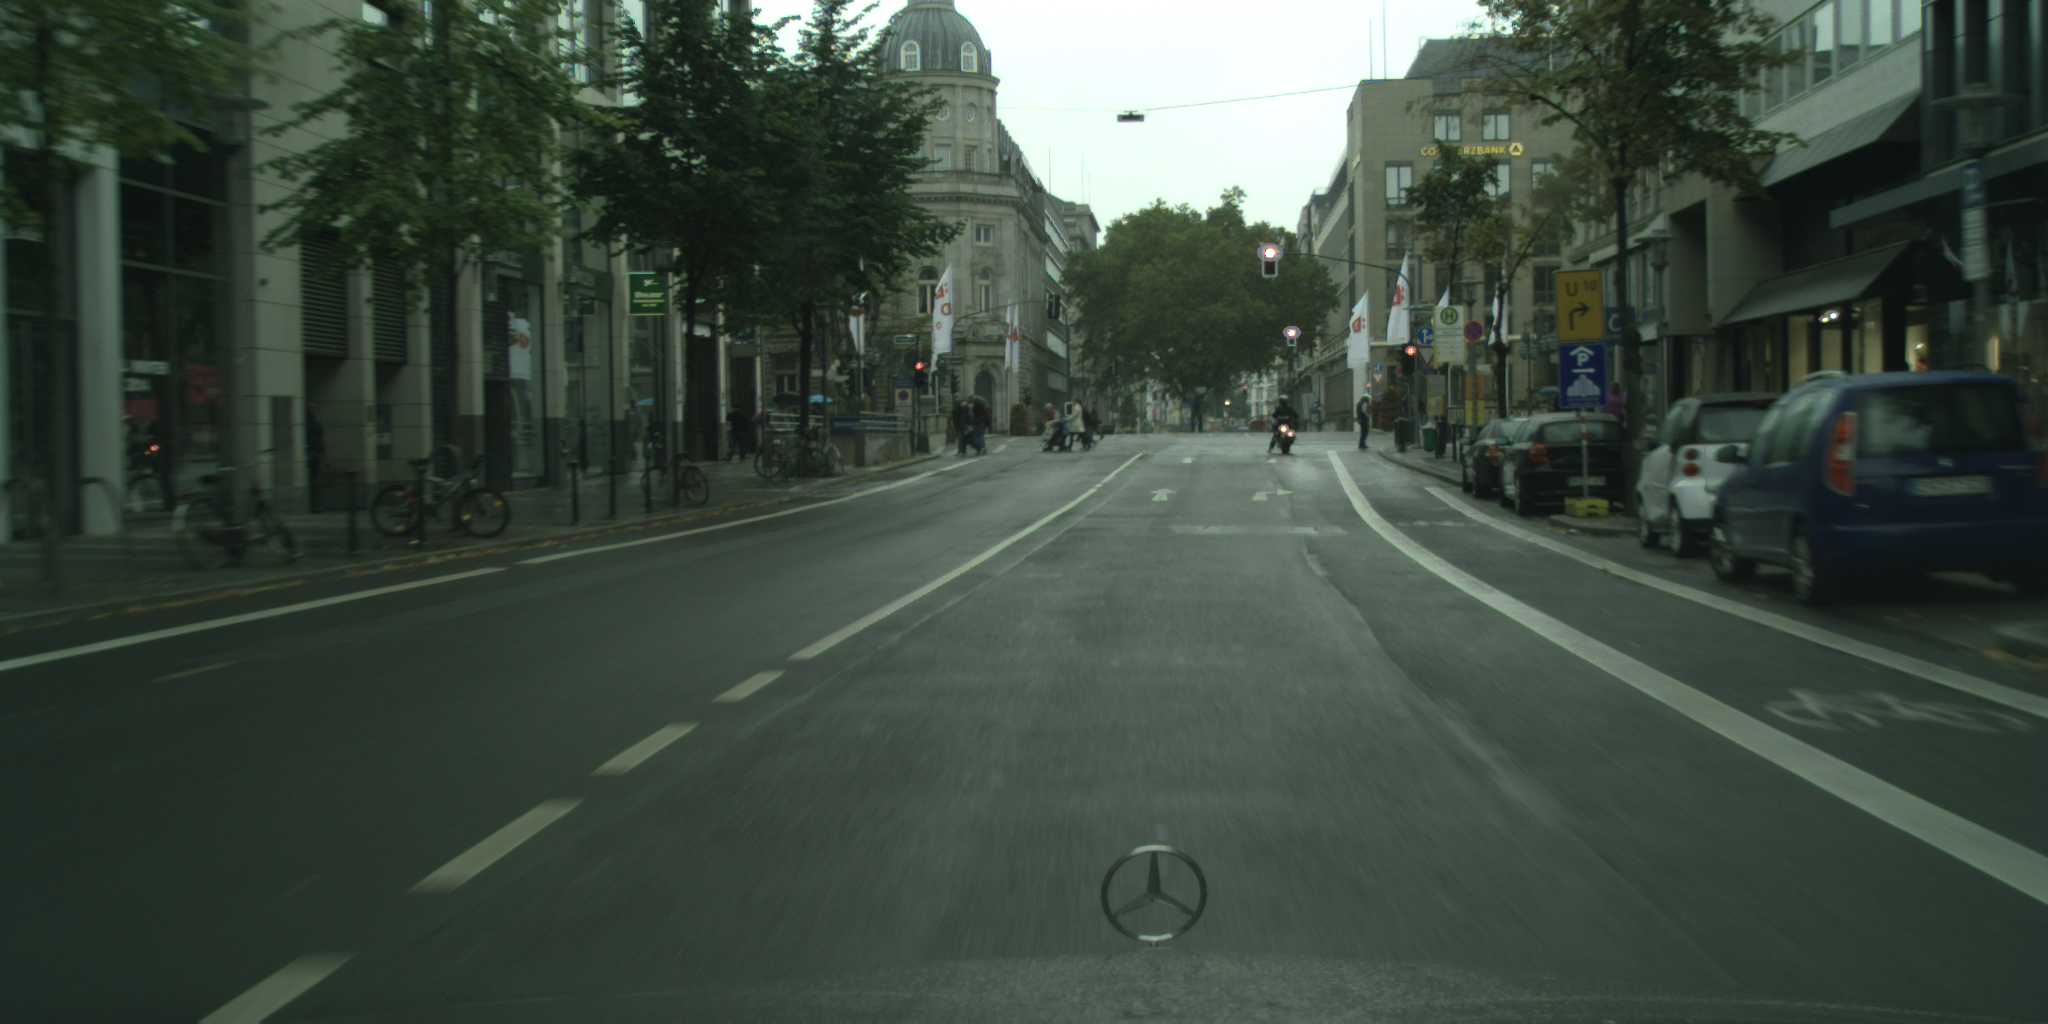

In [13]:
img

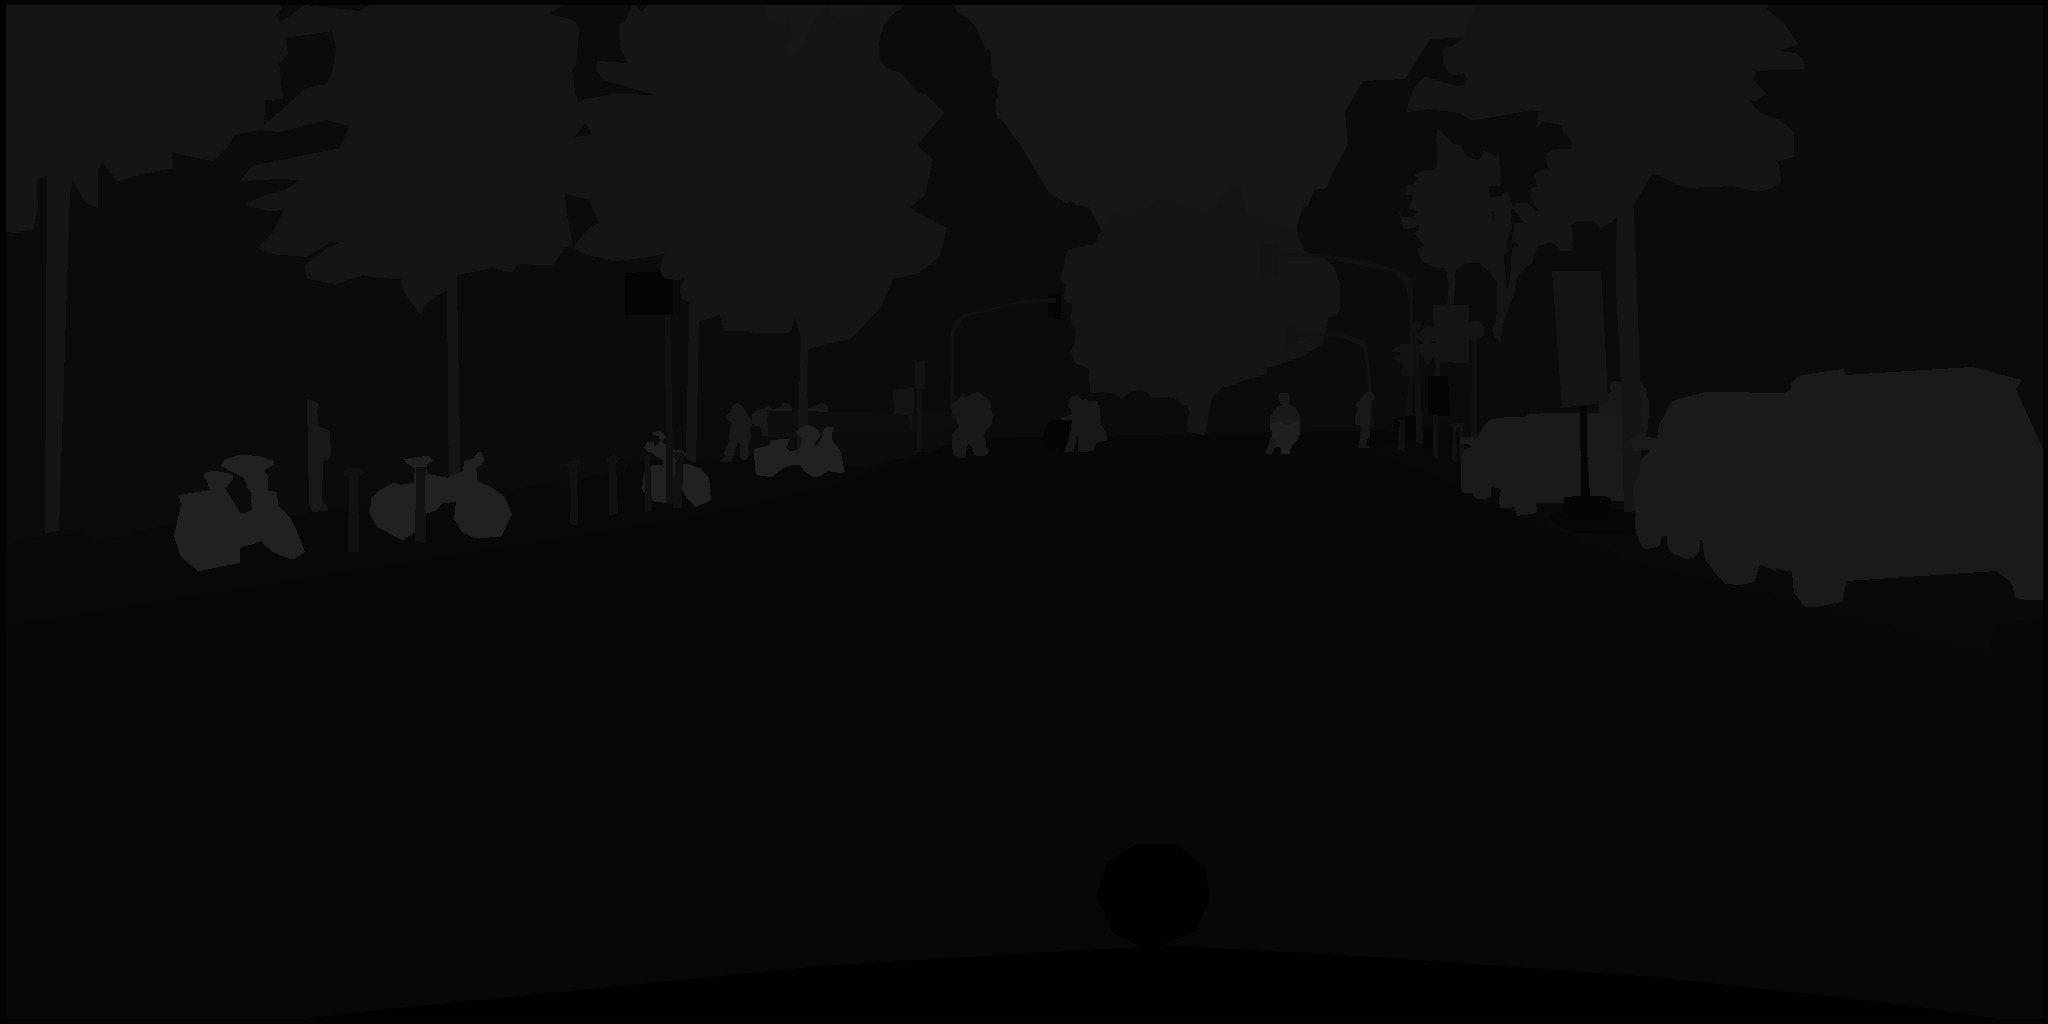

In [14]:
smnt